Testing single simulation...
Success with 75th percentile caliper!
Test result keys: dict_keys(['att_1to1', 'att_1tomany', 'bias_1to1', 'bias_1tomany', 'se_1to1', 'se_1tomany', 'var_1to1', 'var_1tomany', 'caliper', 'mean_qual_1to1', 'mean_qual_1tomany', 'n_matched_1to1', 'n_matched_1tomany'])

Running full Monte Carlo simulation...
Running 100 simulations...
Setup: 100 treated, 500 control
True ATE: 2.0
1-to-many uses k=3 matches per treated unit
Caliper set at 75th percentile of 1-to-1 Hungarian distances
Sim 1: Caliper=0.377, 1-to-1 matches=75, 1-to-many matches=139
Sim 2: Caliper=0.460, 1-to-1 matches=75, 1-to-many matches=179
Sim 3: Caliper=0.428, 1-to-1 matches=75, 1-to-many matches=165
Completed 20/100 simulations
Completed 40/100 simulations
Completed 60/100 simulations
Completed 80/100 simulations
Completed 100/100 simulations
Successful simulations: 100/100
Failed simulations: 0/100
Average caliper: 0.459
Results DataFrame shape: (100, 13)
Columns: ['att_1to1', 'att_1tomany', 

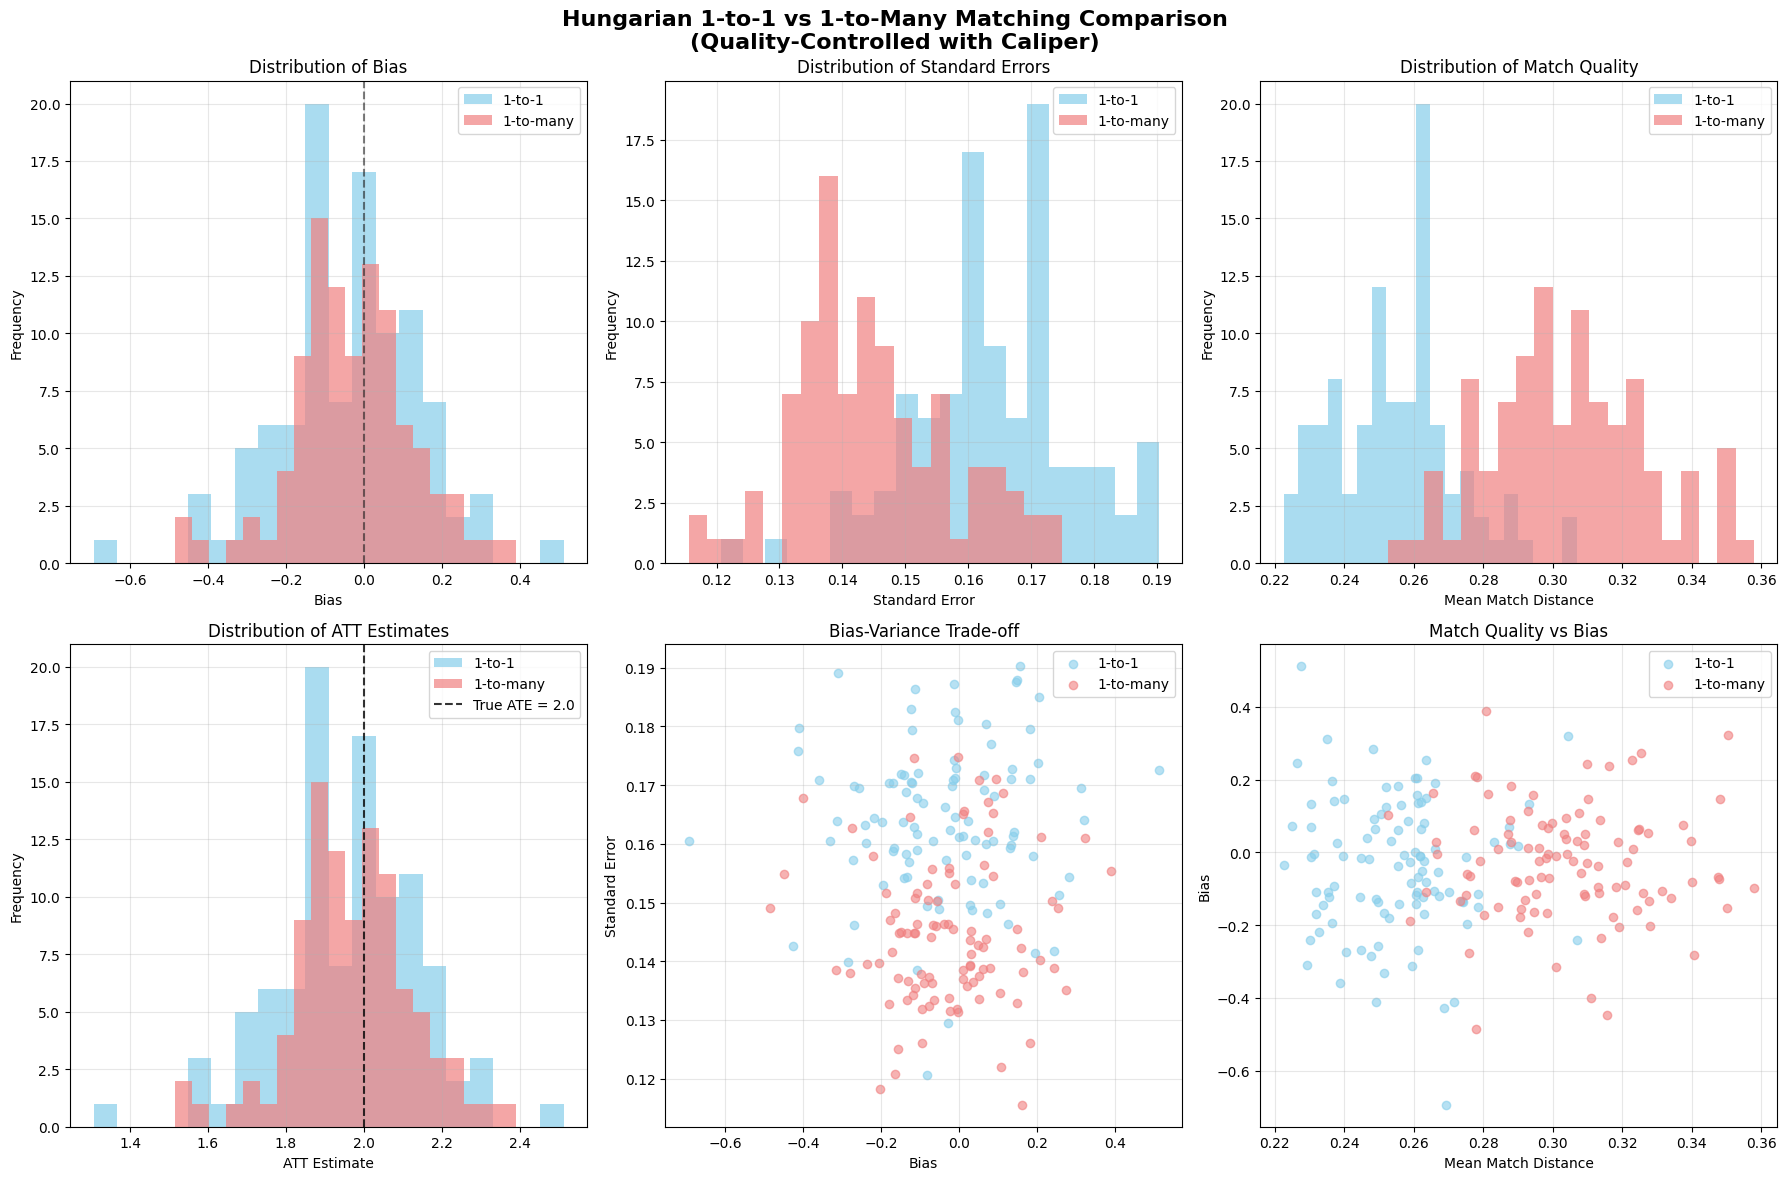


SENSITIVITY ANALYSIS: VARYING NUMBER OF MATCHES (k) WITH QUALITY CONTROL

Testing k=1...
Running 50 simulations...
Setup: 100 treated, 500 control
True ATE: 2.0
1-to-many uses k=1 matches per treated unit
Caliper set at 75th percentile of 1-to-1 Hungarian distances
Sim 1: Caliper=0.377, 1-to-1 matches=75, 1-to-many matches=77
Sim 2: Caliper=0.460, 1-to-1 matches=75, 1-to-many matches=79
Sim 3: Caliper=0.428, 1-to-1 matches=75, 1-to-many matches=75
Completed 20/50 simulations
Completed 40/50 simulations
Successful simulations: 50/50
Failed simulations: 0/50
Average caliper: 0.446
Results DataFrame shape: (50, 13)
Columns: ['att_1to1', 'att_1tomany', 'bias_1to1', 'bias_1tomany', 'se_1to1', 'se_1tomany', 'var_1to1', 'var_1tomany', 'caliper', 'mean_qual_1to1', 'mean_qual_1tomany', 'n_matched_1to1', 'n_matched_1tomany']

Testing k=2...
Running 50 simulations...
Setup: 100 treated, 500 control
True ATE: 2.0
1-to-many uses k=2 matches per treated unit
Caliper set at 75th percentile of 1-to-1

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class MatchingSimulation:
    def __init__(self, n_treated=100, n_control=500, n_covariates=3,
                 true_ate=2.0, random_state=42):
        """
        Initialize matching simulation

        Args:
            n_treated: Number of treated units
            n_control: Number of control units
            n_covariates: Number of confounding variables
            true_ate: True average treatment effect
            random_state: Random seed
        """
        self.n_treated = n_treated
        self.n_control = n_control
        self.n_covariates = n_covariates
        self.true_ate = true_ate
        self.random_state = random_state

    def generate_data(self):
        """Generate synthetic data with confounding"""
        np.random.seed(self.random_state)

        # Generate covariates
        # Treated units have slightly different covariate distribution
        X_treated = np.random.normal(0.5, 1, (self.n_treated, self.n_covariates))
        X_control = np.random.normal(0, 1, (self.n_control, self.n_covariates))

        # Generate potential outcomes with confounding
        # Y(0) depends on covariates (confounding)
        coef_confound = np.random.normal(0, 1, self.n_covariates)

        Y0_treated = np.dot(X_treated, coef_confound) + np.random.normal(0, 1, self.n_treated)
        Y0_control = np.dot(X_control, coef_confound) + np.random.normal(0, 1, self.n_control)

        # Y(1) = Y(0) + treatment effect (constant for simplicity)
        Y1_treated = Y0_treated + self.true_ate

        # Observed outcomes
        Y_treated = Y1_treated  # Treated units show Y(1)
        Y_control = Y0_control  # Control units show Y(0)

        return {
            'X_treated': X_treated,
            'X_control': X_control,
            'Y_treated': Y_treated,
            'Y_control': Y_control,
            'Y0_treated': Y0_treated  # True counterfactual for bias calculation
        }

    def compute_distance_matrix(self, X_treated, X_control):
        """Compute distance matrix for matching"""
        # Standardize covariates
        scaler = StandardScaler()
        X_all = np.vstack([X_treated, X_control])
        X_all_scaled = scaler.fit_transform(X_all)

        X_treated_scaled = X_all_scaled[:self.n_treated]
        X_control_scaled = X_all_scaled[self.n_treated:]

        # Compute Euclidean distances
        distances = cdist(X_treated_scaled, X_control_scaled, metric='euclidean')
        return distances

    def compute_caliper(self, distance_matrix, percentile=75):
        """
        Compute caliper as a percentile of 1-to-1 Hungarian distances
        This ensures we maintain similar match quality standards
        """
        # Get 1-to-1 Hungarian matches first
        treated_indices, control_indices = linear_sum_assignment(distance_matrix)
        hungarian_distances = distance_matrix[treated_indices, control_indices]

        # Set caliper at specified percentile of Hungarian distances
        caliper = np.percentile(hungarian_distances, percentile)
        return caliper, hungarian_distances

    def hungarian_1_to_1(self, distance_matrix, caliper=None):
        """Hungarian algorithm for 1-to-1 matching with optional caliper"""
        treated_indices, control_indices = linear_sum_assignment(distance_matrix)

        matches = {}
        excluded_matches = 0

        for i, j in zip(treated_indices, control_indices):
            distance = distance_matrix[i, j]
            if caliper is None or distance <= caliper:
                matches[i] = [j]
            else:
                # If match exceeds caliper, exclude it
                matches[i] = []
                excluded_matches += 1

        # Commented out to reduce output spam
        # if excluded_matches > 0:
        #     print(f"1-to-1: Excluded {excluded_matches} matches exceeding caliper {caliper:.3f}")

        return matches

    def hungarian_1_to_many(self, distance_matrix, k=3, caliper=None):
        """
        Hungarian algorithm for 1-to-many matching via replication with caliper

        Args:
            distance_matrix: n_treated x n_control distance matrix
            k: Number of matches per treated unit
            caliper: Maximum allowable distance for matches
        """
        n_treated, n_control = distance_matrix.shape

        if caliper is not None:
            # Apply caliper by setting distances > caliper to very large value
            distance_matrix_calipered = distance_matrix.copy()
            distance_matrix_calipered[distance_matrix > caliper] = 1e10
        else:
            distance_matrix_calipered = distance_matrix

        # Create expanded distance matrix by replicating treated units
        expanded_distances = np.tile(distance_matrix_calipered, (k, 1))

        # Run Hungarian on expanded problem
        treated_indices, control_indices = linear_sum_assignment(expanded_distances)

        # Convert back to original treated unit indices
        matches = {i: [] for i in range(n_treated)}
        excluded_matches = 0

        for t_idx, c_idx in zip(treated_indices, control_indices):
            original_treated = t_idx % n_treated
            original_distance = distance_matrix[original_treated, c_idx]

            # Only include matches within caliper
            if caliper is None or original_distance <= caliper:
                matches[original_treated].append(c_idx)
            else:
                excluded_matches += 1

        # Commented out to reduce output spam
        # if excluded_matches > 0:
        #     print(f"1-to-many: Excluded {excluded_matches} matches exceeding caliper {caliper:.3f}")

        return matches

    def estimate_att(self, matches, Y_treated, Y_control):
        """Estimate ATT given matches"""
        att_estimates = []

        for treated_idx, control_indices in matches.items():
            treated_outcome = Y_treated[treated_idx]
            control_outcomes = Y_control[control_indices]

            # Individual treatment effect estimate
            individual_ate = treated_outcome - np.mean(control_outcomes)
            att_estimates.append(individual_ate)

        return np.array(att_estimates)

    def run_single_simulation(self, k_many=3, caliper_percentile=75):
        """Run single simulation comparing 1-to-1 vs 1-to-many with quality control"""
        data = self.generate_data()

        # Compute distances
        distances = self.compute_distance_matrix(data['X_treated'], data['X_control'])

        # Compute caliper based on 1-to-1 Hungarian distances
        caliper, hungarian_distances = self.compute_caliper(distances, caliper_percentile)

        # 1-to-1 matching with caliper
        matches_1to1 = self.hungarian_1_to_1(distances, caliper=caliper)

        # 1-to-many matching with same caliper
        matches_1tomany = self.hungarian_1_to_many(distances, k=k_many, caliper=caliper)

        # Calculate match quality statistics
        def get_match_quality(matches, distances):
            all_distances = []
            for treated_idx, control_indices in matches.items():
                for control_idx in control_indices:
                    all_distances.append(distances[treated_idx, control_idx])
            return np.array(all_distances)

        qual_1to1 = get_match_quality(matches_1to1, distances)
        qual_1tomany = get_match_quality(matches_1tomany, distances)

        # Only proceed if we have sufficient matches
        n_matched_1to1 = sum(len(controls) for controls in matches_1to1.values())
        n_matched_1tomany = sum(len(controls) for controls in matches_1tomany.values())

        # Lower the threshold to 50% to get more successful simulations
        min_matches_threshold = self.n_treated * 0.5

        if n_matched_1to1 < min_matches_threshold or n_matched_1tomany < min_matches_threshold:
            # Skip this simulation if too few matches
            return None

        # Estimate ATT - only for units that have matches
        def safe_estimate_att(matches, Y_treated, Y_control):
            att_estimates = []
            for treated_idx, control_indices in matches.items():
                if len(control_indices) > 0:  # Only if this treated unit has matches
                    treated_outcome = Y_treated[treated_idx]
                    control_outcomes = Y_control[control_indices]
                    individual_ate = treated_outcome - np.mean(control_outcomes)
                    att_estimates.append(individual_ate)
            return np.array(att_estimates)

        att_est_1to1 = safe_estimate_att(matches_1to1, data['Y_treated'], data['Y_control'])
        att_est_1tomany = safe_estimate_att(matches_1tomany, data['Y_treated'], data['Y_control'])

        # Skip if no estimates available
        if len(att_est_1to1) == 0 or len(att_est_1tomany) == 0:
            return None

        # Calculate bias (using true counterfactual)
        bias_1to1 = np.mean(att_est_1to1) - self.true_ate
        bias_1tomany = np.mean(att_est_1tomany) - self.true_ate

        # Calculate standard errors
        se_1to1 = np.std(att_est_1to1) / np.sqrt(len(att_est_1to1))
        se_1tomany = np.std(att_est_1tomany) / np.sqrt(len(att_est_1tomany))

        return {
            'att_1to1': np.mean(att_est_1to1),
            'att_1tomany': np.mean(att_est_1tomany),
            'bias_1to1': bias_1to1,
            'bias_1tomany': bias_1tomany,
            'se_1to1': se_1to1,
            'se_1tomany': se_1tomany,
            'var_1to1': np.var(att_est_1to1),
            'var_1tomany': np.var(att_est_1tomany),
            'caliper': caliper,
            'mean_qual_1to1': np.mean(qual_1to1) if len(qual_1to1) > 0 else np.nan,
            'mean_qual_1tomany': np.mean(qual_1tomany) if len(qual_1tomany) > 0 else np.nan,
            'n_matched_1to1': n_matched_1to1,
            'n_matched_1tomany': n_matched_1tomany
        }

    def run_monte_carlo(self, n_simulations=100, k_many=3, caliper_percentile=75):
        """Run Monte Carlo simulation with quality-controlled matching"""
        results = []

        print(f"Running {n_simulations} simulations...")
        print(f"Setup: {self.n_treated} treated, {self.n_control} control")
        print(f"True ATE: {self.true_ate}")
        print(f"1-to-many uses k={k_many} matches per treated unit")
        print(f"Caliper set at {caliper_percentile}th percentile of 1-to-1 Hungarian distances")
        print("="*70)

        successful_sims = 0
        failed_sims = 0
        total_caliper = 0

        for i in range(n_simulations):
            if (i + 1) % 20 == 0:
                print(f"Completed {i + 1}/{n_simulations} simulations")

            # Change random state for each simulation
            self.random_state = 42 + i
            result = self.run_single_simulation(k_many, caliper_percentile)

            if result is not None:  # Only include successful simulations
                results.append(result)
                successful_sims += 1
                total_caliper += result['caliper']

                # Debug output for first few simulations
                if successful_sims <= 3:
                    print(f"Sim {i+1}: Caliper={result['caliper']:.3f}, "
                          f"1-to-1 matches={result['n_matched_1to1']}, "
                          f"1-to-many matches={result['n_matched_1tomany']}")
            else:
                failed_sims += 1

        print(f"Successful simulations: {successful_sims}/{n_simulations}")
        print(f"Failed simulations: {failed_sims}/{n_simulations}")

        if successful_sims > 0:
            print(f"Average caliper: {total_caliper/successful_sims:.3f}")

        # Debug: print shape and columns of results
        df = pd.DataFrame(results)
        print(f"Results DataFrame shape: {df.shape}")
        if len(df) > 0:
            print(f"Columns: {list(df.columns)}")
        else:
            print("WARNING: No successful simulations!")

        return df

    def analyze_results(self, results_df):
        """Analyze Monte Carlo results with match quality assessment"""
        print("\n" + "="*70)
        print("MONTE CARLO RESULTS SUMMARY WITH QUALITY CONTROL")
        print("="*70)

        if len(results_df) == 0:
            print("ERROR: No successful simulations to analyze!")
            print("Try lowering the caliper_percentile or increasing sample sizes.")
            return None

        print(f"Analyzing {len(results_df)} successful simulations")

        # Calculate summary statistics
        summary = {
            'Mean ATT Estimate': {
                '1-to-1': results_df['att_1to1'].mean(),
                '1-to-many': results_df['att_1tomany'].mean()
            },
            'Mean Bias': {
                '1-to-1': results_df['bias_1to1'].mean(),
                '1-to-many': results_df['bias_1tomany'].mean()
            },
            'Mean Standard Error': {
                '1-to-1': results_df['se_1to1'].mean(),
                '1-to-many': results_df['se_1tomany'].mean()
            },
            'Mean Variance': {
                '1-to-1': results_df['var_1to1'].mean(),
                '1-to-many': results_df['var_1tomany'].mean()
            },
            'RMSE': {
                '1-to-1': np.sqrt(np.mean(results_df['bias_1to1']**2)),
                '1-to-many': np.sqrt(np.mean(results_df['bias_1tomany']**2))
            },
            'Mean Match Quality (Distance)': {
                '1-to-1': results_df['mean_qual_1to1'].mean(),
                '1-to-many': results_df['mean_qual_1tomany'].mean()
            },
            'Mean Matches per Treated': {
                '1-to-1': results_df['n_matched_1to1'].mean() / 100,  # per treated unit
                '1-to-many': results_df['n_matched_1tomany'].mean() / 100  # per treated unit
            }
        }

        for metric, values in summary.items():
            print(f"\n{metric}:")
            print(f"  1-to-1:     {values['1-to-1']:.4f}")
            print(f"  1-to-many:  {values['1-to-many']:.4f}")
            if metric != 'Mean Matches per Treated':
                print(f"  Difference: {values['1-to-many'] - values['1-to-1']:.4f}")
            else:
                ratio = values['1-to-many'] / values['1-to-1'] if values['1-to-1'] > 0 else np.nan
                print(f"  Ratio:      {ratio:.2f}")

        print(f"\nMean Caliper: {results_df['caliper'].mean():.4f}")
        print(f"Caliper Std:  {results_df['caliper'].std():.4f}")

        return summary

    def plot_results(self, results_df):
        """Create visualization of results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Hungarian 1-to-1 vs 1-to-Many Matching Comparison',
                     fontsize=16, fontweight='bold')

        # Bias comparison
        axes[0,0].hist(results_df['bias_1to1'], alpha=0.7, label='1-to-1', bins=20, color='skyblue')
        axes[0,0].hist(results_df['bias_1tomany'], alpha=0.7, label='1-to-many', bins=20, color='lightcoral')
        axes[0,0].axvline(0, color='black', linestyle='--', alpha=0.5)
        axes[0,0].set_xlabel('Bias')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Distribution of Bias')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Standard Error comparison
        axes[0,1].hist(results_df['se_1to1'], alpha=0.7, label='1-to-1', bins=20, color='skyblue')
        axes[0,1].hist(results_df['se_1tomany'], alpha=0.7, label='1-to-many', bins=20, color='lightcoral')
        axes[0,1].set_xlabel('Standard Error')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('Distribution of Standard Errors')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # ATT Estimates
        axes[1,0].hist(results_df['att_1to1'], alpha=0.7, label='1-to-1', bins=20, color='skyblue')
        axes[1,0].hist(results_df['att_1tomany'], alpha=0.7, label='1-to-many', bins=20, color='lightcoral')
        axes[1,0].axvline(self.true_ate, color='black', linestyle='--', alpha=0.8,
                         label=f'True ATE = {self.true_ate}')
        axes[1,0].set_xlabel('ATT Estimate')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Distribution of ATT Estimates')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Bias vs SE scatter
        axes[1,1].scatter(results_df['bias_1to1'], results_df['se_1to1'],
                         alpha=0.6, label='1-to-1', color='skyblue')
        axes[1,1].scatter(results_df['bias_1tomany'], results_df['se_1tomany'],
                         alpha=0.6, label='1-to-many', color='lightcoral')
        axes[1,1].set_xlabel('Bias')
        axes[1,1].set_ylabel('Standard Error')
        axes[1,1].set_title('Bias-Variance Trade-off')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_results(self, results_df):
        """Create visualization of results with match quality information"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Hungarian 1-to-1 vs 1-to-Many Matching Comparison\n(Quality-Controlled with Caliper)',
                     fontsize=16, fontweight='bold')

        # Bias comparison
        axes[0,0].hist(results_df['bias_1to1'], alpha=0.7, label='1-to-1', bins=20, color='skyblue')
        axes[0,0].hist(results_df['bias_1tomany'], alpha=0.7, label='1-to-many', bins=20, color='lightcoral')
        axes[0,0].axvline(0, color='black', linestyle='--', alpha=0.5)
        axes[0,0].set_xlabel('Bias')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Distribution of Bias')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Standard Error comparison
        axes[0,1].hist(results_df['se_1to1'], alpha=0.7, label='1-to-1', bins=20, color='skyblue')
        axes[0,1].hist(results_df['se_1tomany'], alpha=0.7, label='1-to-many', bins=20, color='lightcoral')
        axes[0,1].set_xlabel('Standard Error')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('Distribution of Standard Errors')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Match Quality comparison
        axes[0,2].hist(results_df['mean_qual_1to1'], alpha=0.7, label='1-to-1', bins=20, color='skyblue')
        axes[0,2].hist(results_df['mean_qual_1tomany'], alpha=0.7, label='1-to-many', bins=20, color='lightcoral')
        axes[0,2].set_xlabel('Mean Match Distance')
        axes[0,2].set_ylabel('Frequency')
        axes[0,2].set_title('Distribution of Match Quality')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)

        # ATT Estimates
        axes[1,0].hist(results_df['att_1to1'], alpha=0.7, label='1-to-1', bins=20, color='skyblue')
        axes[1,0].hist(results_df['att_1tomany'], alpha=0.7, label='1-to-many', bins=20, color='lightcoral')
        axes[1,0].axvline(self.true_ate, color='black', linestyle='--', alpha=0.8,
                         label=f'True ATE = {self.true_ate}')
        axes[1,0].set_xlabel('ATT Estimate')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Distribution of ATT Estimates')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Bias vs SE scatter
        axes[1,1].scatter(results_df['bias_1to1'], results_df['se_1to1'],
                         alpha=0.6, label='1-to-1', color='skyblue')
        axes[1,1].scatter(results_df['bias_1tomany'], results_df['se_1tomany'],
                         alpha=0.6, label='1-to-many', color='lightcoral')
        axes[1,1].set_xlabel('Bias')
        axes[1,1].set_ylabel('Standard Error')
        axes[1,1].set_title('Bias-Variance Trade-off')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        # Match Quality vs Bias
        axes[1,2].scatter(results_df['mean_qual_1to1'], results_df['bias_1to1'],
                         alpha=0.6, label='1-to-1', color='skyblue')
        axes[1,2].scatter(results_df['mean_qual_1tomany'], results_df['bias_1tomany'],
                         alpha=0.6, label='1-to-many', color='lightcoral')
        axes[1,2].set_xlabel('Mean Match Distance')
        axes[1,2].set_ylabel('Bias')
        axes[1,2].set_title('Match Quality vs Bias')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Run the simulation
if __name__ == "__main__":
    # Initialize simulation
    sim = MatchingSimulation(
        n_treated=100,
        n_control=500,  # 5x more controls than treated
        n_covariates=3,
        true_ate=2.0
    )

    # First, test with a single simulation to debug
    print("Testing single simulation...")
    test_result = sim.run_single_simulation(k_many=3, caliper_percentile=75)
    if test_result is None:
        print("Single simulation failed! Trying with more lenient caliper...")
        test_result = sim.run_single_simulation(k_many=3, caliper_percentile=90)
        if test_result is None:
            print("Still failing. Trying without caliper...")
            # Test without quality control first
            data = sim.generate_data()
            distances = sim.compute_distance_matrix(data['X_treated'], data['X_control'])
            print(f"Distance matrix shape: {distances.shape}")
            print(f"Distance matrix range: {distances.min():.3f} to {distances.max():.3f}")
            matches_1to1 = sim.hungarian_1_to_1(distances, caliper=None)
            print(f"1-to-1 matches: {sum(len(v) for v in matches_1to1.values())}")
        else:
            print("Success with 90th percentile caliper!")
    else:
        print("Success with 75th percentile caliper!")
        print(f"Test result keys: {test_result.keys()}")

    # Run Monte Carlo simulation with quality control
    print("\nRunning full Monte Carlo simulation...")
    results = sim.run_monte_carlo(n_simulations=100, k_many=3, caliper_percentile=75)

    # Analyze results only if we have some
    if len(results) > 0:
        summary = sim.analyze_results(results)

        # Create plots
        sim.plot_results(results)

        # Additional analysis: vary k with quality control
        print("\n" + "="*70)
        print("SENSITIVITY ANALYSIS: VARYING NUMBER OF MATCHES (k) WITH QUALITY CONTROL")
        print("="*70)

        k_values = [1, 2, 3, 4, 5]
        k_results = []

        for k in k_values:
            print(f"\nTesting k={k}...")
            sim_k = MatchingSimulation(n_treated=100, n_control=500, n_covariates=3, true_ate=2.0)
            results_k = sim_k.run_monte_carlo(n_simulations=50, k_many=k, caliper_percentile=75)

            if len(results_k) > 0:  # Only analyze if we have results
                k_results.append({
                    'k': k,
                    'mean_bias': results_k['bias_1tomany'].mean(),
                    'mean_se': results_k['se_1tomany'].mean(),
                    'rmse': np.sqrt(np.mean(results_k['bias_1tomany']**2)),
                    'mean_quality': results_k['mean_qual_1tomany'].mean(),
                    'n_sims': len(results_k)
                })

        k_df = pd.DataFrame(k_results)
        print("\nSummary across different k values (quality-controlled):")
        print(k_df.round(4))

        # Compare different caliper thresholds
        print("\n" + "="*70)
        print("SENSITIVITY ANALYSIS: VARYING CALIPER THRESHOLD")
        print("="*70)

        caliper_percentiles = [50, 60, 70, 75, 80, 90, 95]
        caliper_results = []

        for percentile in caliper_percentiles:
            print(f"\nTesting caliper at {percentile}th percentile...")
            sim_cal = MatchingSimulation(n_treated=100, n_control=500, n_covariates=3, true_ate=2.0)
            results_cal = sim_cal.run_monte_carlo(n_simulations=30, k_many=3, caliper_percentile=percentile)

            if len(results_cal) > 0:
                caliper_results.append({
                    'caliper_percentile': percentile,
                    'mean_caliper': results_cal['caliper'].mean(),
                    'bias_1to1': results_cal['bias_1to1'].mean(),
                    'bias_1tomany': results_cal['bias_1tomany'].mean(),
                    'se_1to1': results_cal['se_1to1'].mean(),
                    'se_1tomany': results_cal['se_1tomany'].mean(),
                    'quality_1to1': results_cal['mean_qual_1to1'].mean(),
                    'quality_1tomany': results_cal['mean_qual_1tomany'].mean(),
                    'n_sims': len(results_cal)
                })

        caliper_df = pd.DataFrame(caliper_results)
        print("\nSummary across different caliper thresholds:")
        print(caliper_df.round(4))
    else:
        print("No successful simulations to analyze!")
        print("Try running with a higher caliper percentile (e.g., 90 or 95)")